In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import censoring
from scipy.special import logit, expit

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [34]:
# load data
df = pd.read_csv(censoring.data_path)

In [35]:
# limit to the puzzle in which we last have words (396)
df2 = df[ df['PuzzleNum'] != 396].copy()
# convert all Xs
df2['FinalScore'] = np.where((df2.FinalScore == 'X'),'6',df2.FinalScore)
# impute missing scrabble points to be zero
#df2['ScrabblePoints'] = df2['ScrabblePoints'].fillna(0)
# convert dtypes
df2 = df2.astype({
    'Date_Time': 'datetime64', 
    'FinalScore': 'int64', 
    #'ScrabblePoints': 'int64'
})
#create number of fails
df2['Fails'] = df2['FinalScore'] - 1

In [36]:
df2.head()

,Date_Time,Name,Game,PuzzleNum,FinalScore,Answer,ScrabblePoints,Fails
0,2021-12-31 10:46:00,Player1,Wordle,195,6,unify,11.0,5
1,2021-12-31 10:47:00,Player2,Wordle,195,6,unify,11.0,5
2,2021-12-31 11:02:00,Player3,Wordle,195,3,unify,11.0,2
3,2021-12-31 13:46:00,Player4,Wordle,195,5,unify,11.0,4
4,2022-01-01 11:58:00,Player3,Wordle,196,5,rebus,7.0,4


In [37]:
name_factor, player_names = pd.factorize(df2['Name'])

In [38]:
coords = {"obs": df2.index.values,  "player_names": player_names}

## Model 0 - so far the best model

In [39]:
with pm.Model(coords=coords) as BB_model0:
    # hyperprior
    Hα = pm.Gamma("Hα", alpha=3, beta=3) 
    Hβ = pm.Gamma("Hβ", alpha=3, beta=3) 
    # prior
    Θα = pm.Poisson("Θα", mu=Hα, dims="player_names")
    Θβ = pm.Poisson("Θβ", mu=Hβ, dims="player_names")
    
    # likelihood
    Fails = pm.BetaBinomial("Fails", n=6, alpha=Θα[name_factor], beta=Θβ[name_factor], observed=df2["Fails"].values, dims="obs")

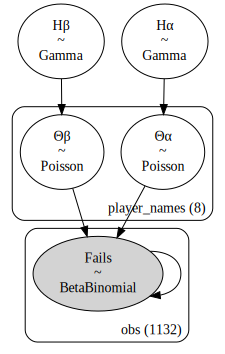

In [49]:
pm.model_to_graphviz(BB_model0)

In [40]:
with BB_model0:
    trace0 = pm.sample(
        2000,
        tune=2000,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Hα, Hβ]
>CompoundStep
>>Metropolis: [Θα]
>>Metropolis: [Θβ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.


## Model 1

In [41]:
with pm.Model(coords=coords) as BB_model1:
    # hyperprior
    Hα = pm.Gamma("Hα", alpha=3, beta=3) 
    Hβ = pm.Gamma("Hβ", alpha=3, beta=3) 
    Ηϵ = pm.Gamma("Ηϵ", alpha=3, beta=3)
    # error
    ϵ = pm.Poisson("ϵ", mu=Ηϵ)
    # prior
    Θα = pm.Poisson("Θα", mu=Hα, dims="player_names")
    Θβ = pm.Poisson("Θβ", mu=Hβ, dims="player_names")
    
    # likelihood
    Fails = pm.BetaBinomial("Fails", n=6, alpha=Θα[name_factor] + ϵ, beta=Θβ[name_factor] + ϵ, observed=df2["Fails"].values, dims="obs")

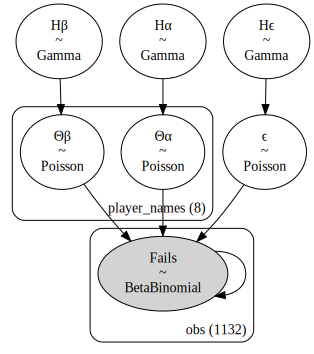

In [50]:
pm.model_to_graphviz(BB_model1)

In [42]:
with BB_model1:
    trace1 = pm.sample(
        2000,
        tune=2000,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Hα, Hβ, Ηϵ]
>CompoundStep
>>Metropolis: [ϵ]
>>Metropolis: [Θα]
>>Metropolis: [Θβ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
The acceptance probability does not match the target. It is 0.8949, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874, but should be close to 0.8. Try to increase the number of tuning steps.


## Compare

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

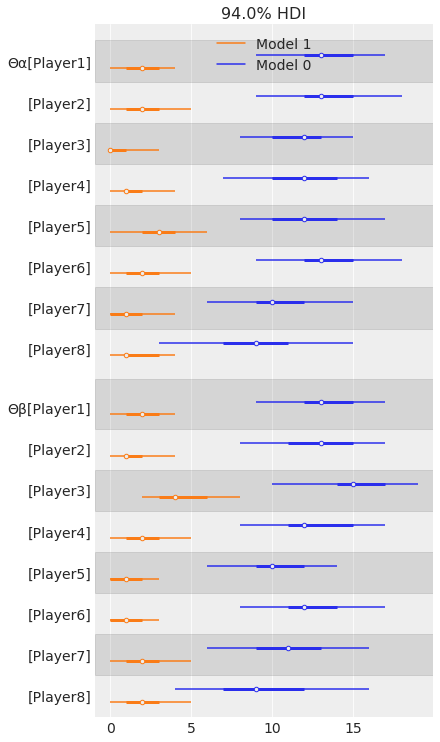

In [43]:
az.plot_forest([trace0, trace1], var_names=['Θα', 'Θβ'], combined=True)

In [44]:
az.waic(trace0)

Computed from 8000 posterior samples and 1132 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1699.57    10.05
p_waic        4.85        -

In [45]:
az.waic(trace1)

Computed from 8000 posterior samples and 1132 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1677.09    11.12
p_waic        3.13        -

In [46]:
az.compare({'BB': trace0, 'BB2': trace1}, 'waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
BB2,0,-1677.085655,3.127785,0.000000,1.000000e+00,11.117479,0.00000,False,log
BB,1,-1699.566092,4.850778,22.480437,4.522605e-12,10.049915,1.83681,False,log


In [47]:
az.summary(trace0, var_names=['Θα', 'Θβ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Θα[Player1],13.488,2.343,9.0,17.0,0.206,0.146,128.0,201.0,1.02
Θα[Player2],13.510,2.666,9.0,18.0,0.289,0.205,84.0,195.0,1.05
Θα[Player3],11.805,1.957,8.0,15.0,0.148,0.105,173.0,223.0,1.01
Θα[Player4],12.231,2.516,7.0,16.0,0.234,0.166,116.0,299.0,1.03
Θα[Player5],12.238,2.619,8.0,17.0,0.213,0.151,149.0,178.0,1.03
Θα[Player6],13.395,2.657,9.0,18.0,0.385,0.274,44.0,132.0,1.08
Θα[Player7],10.443,2.616,6.0,15.0,0.174,0.123,225.0,408.0,1.02
Θα[Player8],9.207,3.374,3.0,15.0,0.148,0.104,533.0,1600.0,1.00
Θβ[Player1],13.356,2.342,9.0,17.0,0.208,0.148,125.0,175.0,1.02
Θβ[Player2],12.987,2.574,8.0,17.0,0.280,0.199,84.0,186.0,1.05
